## P2P Online Lending Default Prediction- A Usecase on LendingClub Default Risk

Mavis Wong, Yasmin Hassan and Abeba N. Turi

In [77]:
# Import 
import os
import numpy as np
import pandas as pd
import altair as alt
import pandera as pa
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import set_config

# Enable the VegaFusion data transformer
alt.data_transformers.enable("vegafusion")

NoSuchEntryPoint: No 'vegafusion' entry point found in group 'altair.vegalite.v5.data_transformer'

### 1. Summary<br>
This work intends to leaverage machine learning models to predict borrower behaviour and hence probability of default. More specifically, the work focuses aszxon predicting loan defaults using historical data from the Lending Club platform. By applying advanced preprocessing techniques, exploratory data analysis (EDA), and a Logistic Regression model, we uncover patterns and trends in borrower risk profiles. The final model demonstrated strong performance on unseen test data, achieving an accuracy of 84.0%. Out of 1,916 test cases, the model correctly predicted 1,608 cases, with 308 incorrect predictions. These errors included both false positives (predicting a loan default when it didn’t occur) and false negatives (failing to predict an actual default).
While false negatives pose a greater risk in financial decision-making, this model provides actionable insights to improve risk management and reduce potential financial losses for the platform. Despite its promising predictive capabilities, further research is needed to enhance the model's accuracy and better understand the characteristics of misclassified loans. Such improvements could play a crucial role in minimizing financial risks and maximizing the model’s effectiveness in peer-to-peer lending platforms.

### 2. Introduction <br>
Crowd-based business models are one of the last decade’s developments with the proliferation of platform economies and web technology applications (see Sutherland and Jarrahi, 2018). One of such developments following the 2007 financial crisis are the P2P online lending platforms. The backbone of the digital economic system built on this is that it relies on trust a currency. Like all other crowd-based business models, P2P online lending heavily relied on trustworthiness of borrowers. To help with this, online platforms like LendingClub used a number of features to define eligibility and rate of access to loan for potential borrowers.Traditional credit risk analysis often relies on rule-based systems or credit scores, which might not fully capture the complexities of borrower behavior. By applying Logistic Regression, we aim to develop a model that is both interpretable and effective in identifying high-risk loans. This analysis intends to provide a data-driven approach to improve credit decision-making in a broader context of platform based transactions through machine learning models.
Extensive research has been conducted on borrower risk behaviour analysis and trust within P2P online lending system, highlighting the critical role trust and predictability holds in ensuring platform sustainability and mitigating default risks (Cai, et al, 2016 and Lenz, 2016). Building on this, this work focuses on developing a comprehensive risk analysis framework through machine hlearning models that will help predict borrower behaviour.



### 3. Methods <br>

#### 3.1 Data <br>
##### Data Source
This analysis is based on the historic loan data from LendingClub (LendingClub. (n.d.) and Matmcreative. (n.d.).).
It contains various borrower and loan features, such as interest rates, annual income, debt-to-income ratio (DTI), and credit history. The target variable, not.fully.paid, indicates whether the borrower defaulted on the loan (1) or successfully repaid it (0).

##### Feature Description
The key features taken into account for this analysis are:

`purpose`: The purpose of the loan

`int.rate`: Interest rate of the loan the applicant received 

`installment`: Monthly payment for the loan the applicant received.

`log.annual.inc`: annual_income (growth rate)

`dti`: Debt-to-income ratio

`revol.bal`: Total credit revolving balance

`revol.util`: Revolving line utilization rate

`inq.last.6mths`: The number of inquiries in past 6 months

`delinq.2yrs`: Delinquencies on lines of credit in the last 2 years.

`pub.rec`: The number of derogatory public records

`fico`: FICO credit score

`days.with.cr.line`: Days with Credit Line

`not.fully.paid`: Binary response on weather the loan is paid or not.

##### Data Splitting to Training and Testing Data

Train-Test Split: 

The dataset was split into training (80%) and test (20%) sets, resulting in 1916 observations in the test set.
Features: The model was trained on both numeric features (e.g., int.rate, installment) and categorical features (e.g., purpose, loan_categories).

Preprocessing: 

Numeric features were scaled using StandardScaler, while categorical features were one-hot encoded. Missing values were imputed using the median (numeric) or most frequent value (categorical).


#### 3.2 Analysis <br>
- Train-Test Split:
The dataset was split into training (80%) and test (20%) sets, resulting in 1916 observations in the test set. <br>

- Features: 
The model was trained on both numeric features (e.g., int.rate, installment) and categorical features (e.g., purpose, loan_categories).

- Preprocessing: 
Numeric features were scaled using StandardScaler, while categorical features were one-hot encoded. Missing values were imputed using the median (numeric) or most frequent value (categorical).

- Model:
Logistic Regression was selected as the final model for its simplicity, slightly higher accuracy, and interpretability. 
All columns except `risk_category` were used in model fitting. `risk_category` was drop due to it being redundant to "loan_categories" (both derived from "fico" score).
A grid search with 10-fold cross-validation on the hyperparameter `C` of the logistic regression model is used for optimization. 
Python language was used to conduct this analysis.

### 4. Results and Discussion <br>

In order for us to draw context about the data, let us have a look at the first few rows of the data; check the info about all columns, data types, and number of NaN values; and summary statistis.

In [59]:
# Define the project root directory (adjust the path if needed)
file_path = os.path.join("..", "data", "raw", "loan_data.csv")

p2ploan_df = pd.read_csv(file_path)


# Check the data
p2ploan_df.head()


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [60]:
p2ploan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [61]:
# Data Validation
check_prop = pa.Check(lambda s: s.isna().mean() <= 0.05,
                      element_wise=False,
                      error="Too many null values in 'credit.policy' column.")
schema = pa.DataFrameSchema(
    {
        "credit.policy": pa.Column(int, 
                                   checks=[check_prop,
                                           pa.Check.isin([0, 1])], 
                                   nullable=True),
        "purpose": pa.Column(
            str, 
            checks=[check_prop,
                    pa.Check.isin([
                        "debt_consolidation", 
                        "all_other", 
                        "credit_card", 
                        "home_improvement", 
                        "small_business", 
                        "major_purchase", 
                        "educational"
            ])],
            nullable=True),
        "int.rate": pa.Column(float, checks=[check_prop,pa.Check.in_range(0, 1)], nullable=True),
        "installment": pa.Column(float, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "log.annual.inc": pa.Column(float, checks=[check_prop,pa.Check.ge(1)], nullable=True),
        "dti": pa.Column(float, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "fico": pa.Column(int, checks=[check_prop,pa.Check.in_range(300, 900)], nullable=True),
        "days.with.cr.line": pa.Column(float, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "revol.bal": pa.Column(int, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "revol.util": pa.Column(float, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "inq.last.6mths": pa.Column(int, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "delinq.2yrs": pa.Column(int, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "pub.rec": pa.Column(int, checks=[check_prop,pa.Check.ge(0)], nullable=True),
        "not.fully.paid": pa.Column(int, checks=[check_prop,pa.Check.isin([0, 1])], nullable=True),
    },
    checks = [
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found.")
    ]
    
)

schema.validate(p2ploan_df)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


#### 4.1 Data splitting 

Split the data into `train_df` (80%) and `test_df` (20%) with `random_state = 522`.

In [62]:
train_df, test_df = train_test_split(p2ploan_df, test_size=0.2, random_state=522)

# Save train data and test data to csv
train_df.to_csv("../data/processed/loan_train.csv")
test_df.to_csv("../data/processed/loan_test.csv")

In [63]:
# Data Validation: Anomalous Correlations
train_corr = train_df.corr(numeric_only=True)
pd.DataFrame(train_corr).style.format(
precision=2
).background_gradient(
    cmap="coolwarm", vmin=-1, vmax=1
).highlight_between(
    left=0.8,right=1, color="black"
).highlight_between(
    left=-1,right=-0.8, color="black"
)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
credit.policy,1.00,-0.29,0.06,0.03,-0.08,0.34,0.09,-0.19,-0.10,-0.53,-0.07,-0.06,-0.15
int.rate,-0.29,1.00,0.28,0.06,0.22,-0.71,-0.12,0.09,0.46,0.20,0.16,0.10,0.17
installment,0.06,0.28,1.00,0.44,0.05,0.08,0.18,0.23,0.08,-0.00,-0.00,-0.03,0.06
log.annual.inc,0.03,0.06,0.44,1.00,-0.06,0.11,0.34,0.37,0.06,0.02,0.02,0.02,-0.03
dti,-0.08,0.22,0.05,-0.06,1.00,-0.24,0.05,0.18,0.34,0.02,-0.02,-0.00,0.03
fico,0.34,-0.71,0.08,0.11,-0.24,1.00,0.25,-0.01,-0.54,-0.18,-0.22,-0.15,-0.15
days.with.cr.line,0.09,-0.12,0.18,0.34,0.05,0.25,1.00,0.23,-0.02,-0.04,0.09,0.08,-0.03
revol.bal,-0.19,0.09,0.23,0.37,0.18,-0.01,0.23,1.00,0.20,0.03,-0.03,-0.03,0.06
revol.util,-0.10,0.46,0.08,0.06,0.34,-0.54,-0.02,0.20,1.00,-0.02,-0.04,0.07,0.08
inq.last.6mths,-0.53,0.20,-0.00,0.02,0.02,-0.18,-0.04,0.03,-0.02,1.00,0.01,0.08,0.15


In [64]:
# Data Validation: Target Distribution
print(train_df["not.fully.paid"].value_counts(normalize=True))
print(test_df["not.fully.paid"].value_counts(normalize=True))

not.fully.paid
0    0.839859
1    0.160141
Name: proportion, dtype: float64
not.fully.paid
0    0.840292
1    0.159708
Name: proportion, dtype: float64


In [65]:
train_df.shape

(7662, 14)

In [66]:
# Summary Statistics
train_df.describe(include="all")

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,7662.000000,7662,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7.662000e+03,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000
unique,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,debt_consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.807883,NaN,0.122498,318.706990,10.932388,12.626631,710.975463,4574.926113,1.717180e+04,46.870501,1.566562,0.159358,0.062386,0.160141
std,0.393990,NaN,0.026774,207.488994,0.614014,6.867246,37.763921,2508.344473,3.518355e+04,28.941005,2.166408,0.531531,0.263564,0.366761
min,0.000000,NaN,0.060000,15.670000,7.547502,0.000000,612.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,NaN,0.103900,163.570000,10.555813,7.260000,682.000000,2820.000000,3.224250e+03,22.800000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,NaN,0.122100,267.740000,10.918718,12.730000,707.000000,4140.041667,8.707500e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,NaN,0.139300,435.540000,11.289832,17.940000,737.000000,5730.041667,1.837150e+04,70.900000,2.000000,0.000000,0.000000,0.000000


In [67]:
# Let us store the column names of the columns with missing values as a list in a variable called missing_vals_cols.
missing_vals_cols = train_df.columns[train_df.isna().sum() > 0].tolist()

# Define numeric columns explicitly
numeric_cols = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
    'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'annual.inc']

### 4.2 Feature Engineering

In [68]:
# income- level data
train_df['annual.inc'] = np.exp(train_df['log.annual.inc'])
test_df['annual.inc'] = np.exp(test_df['log.annual.inc'])

Here, from a business perspective, we need to identify high-risk and low-risk loan profiles to improve lending profitability while minimizing default rates. 
This includes assessing borrower behavior, income stability, and loan utilization to create a predictive model for effective risk categorization (see  Coşer et al., 2019 and Khandani et al.,2010).

Key metrix and considerations:
- Debt-to-Income Ratio 
- Credit Utilization Ratio( revol.util)_ how much of their revolving credit borrowers are using relative to their limit with higher values indicating possible financial strain.
- Loan Duration vs. Risk: If longer-term loans are associated with higher default rate (days.with.cr.line).

##### Loan categories
Below, to help us create the loan categories, we are using the FICO risk profile categories  [see the Borrower risk profiles categories from here](https://www.consumerfinance.gov/data-research/consumer-credit-trends/student-loans/borrower-risk-profiles/#:~:text=We%20focus%20on%20five%20credit%20score%20levels%3A&text=Subprime%20(credit%20scores%20of%20580,scores%20of%20720%20or%20above)
- Deep subprime (credit scores below 580)
- Subprime (credit scores of 580-619)
- Near-prime (credit scores of 620-659)
- Prime (credit scores of 660-719)
- Super-prime (credit scores of 720 or above)


In [69]:
train_df['loan_income_ratio'] = (train_df['installment'] * 12) / train_df['annual.inc']

# Creating loan Categories
conditions = [
    (train_df['fico'] >= 720),
    (train_df['fico'] < 719) & (train_df['fico'] >= 660),
    (train_df['fico'] < 659) & (train_df['fico'] >= 620),
    (train_df['fico'] < 619) & (train_df['fico'] >= 580),
    (train_df['fico'] < 580)
]
loan_categories = ['Super-prime', 'Prime', 'Near-prime', 'Subprime', 'Deep subprime']
train_df['loan_categories'] = np.select(conditions, loan_categories, default='Unknown')

test_df['loan_income_ratio'] = (test_df['installment'] * 12) / test_df['annual.inc']
conditions = [
    (test_df['fico'] >= 720),
    (test_df['fico'] < 719) & (test_df['fico'] >= 660),
    (test_df['fico'] < 659) & (test_df['fico'] >= 620),
    (test_df['fico'] < 619) & (test_df['fico'] >= 580),
    (test_df['fico'] < 580)
]
test_df['loan_categories'] = np.select(conditions, loan_categories, default='Unknown')

##### Risk categories
Let us explore the data further with specific borrower risk profile categories 
Based on the above 5 loan categories, we framed three main risk categories as high, medium and low risk profile with: 
fico score of at least 720 (Low Risk), 'fico' score between 650 and 720 ('Medium Risk') and 'fico' score of 650 as 'High Risk'. 

In [70]:
# Creating Risk Categories
conditions = [
    (train_df['fico'] >= 720),
    (train_df['fico'] < 720) & (train_df['fico'] >= 650),
    (train_df['fico'] < 650)
]
categories = ['Low Risk', 'Medium Risk', 'High Risk']
train_df['risk_category'] = np.select(conditions, categories, default='Unknown')

conditions = [
    (test_df['fico'] >= 720),
    (test_df['fico'] < 720) & (test_df['fico'] >= 650),
    (test_df['fico'] < 650)
]
test_df['risk_category'] = np.select(conditions, categories, default='Unknown')


#### 4.3 Descriptive Analysis- EDA

To evaluate the usefulness of predictors for identifying loan defaults, we conducted an exploratory data analysis. Features such as int.rate (interest rate) and dti (debt-to-income ratio) displayed notable differences between borrowers who fully paid their loans and those who defaulted. For example, loans with higher interest rates (int.rate) were associated with a greater likelihood of default, while borrowers with lower debt-to-income ratios (dti) were less likely to default. Categorical features like purpose also provided significant insights; loans categorized under "small business" and "credit card" showed higher default rates compared to others, such as "home improvement."


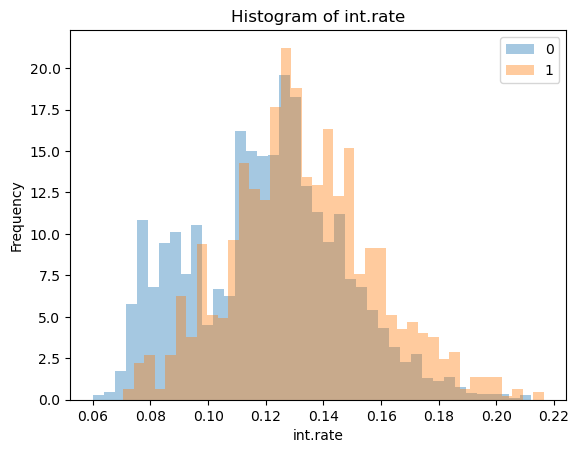

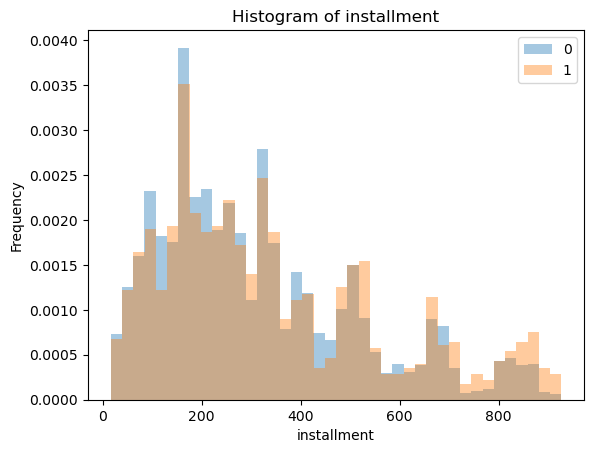

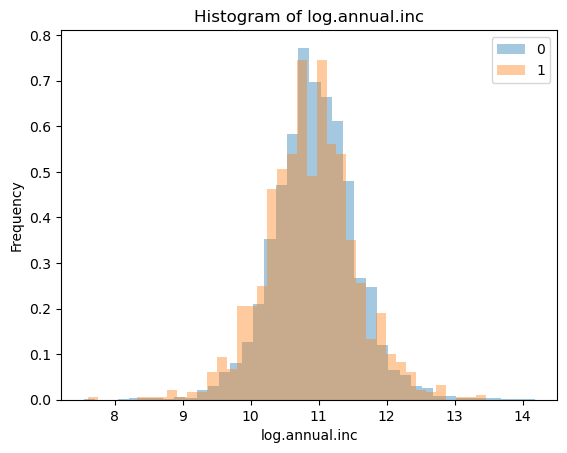

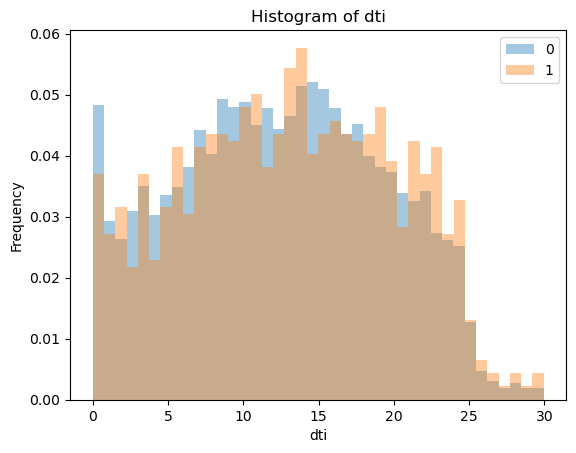

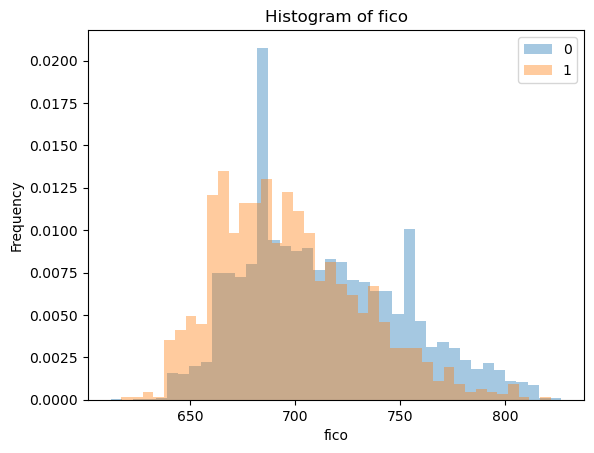

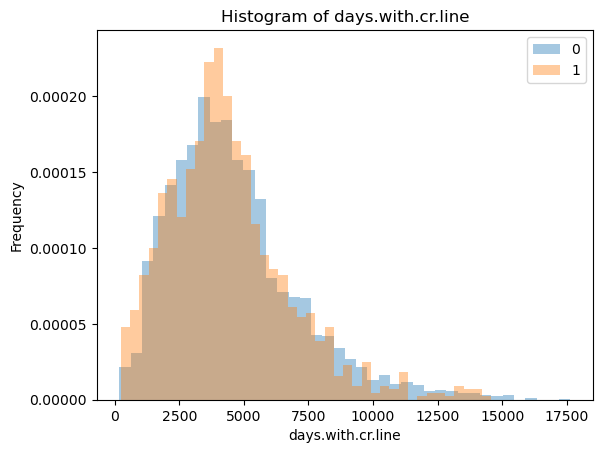

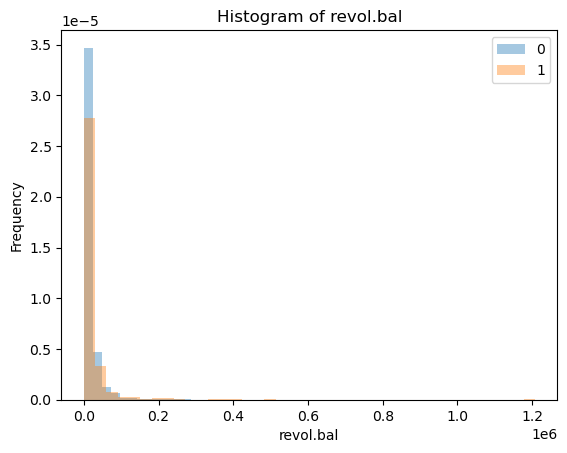

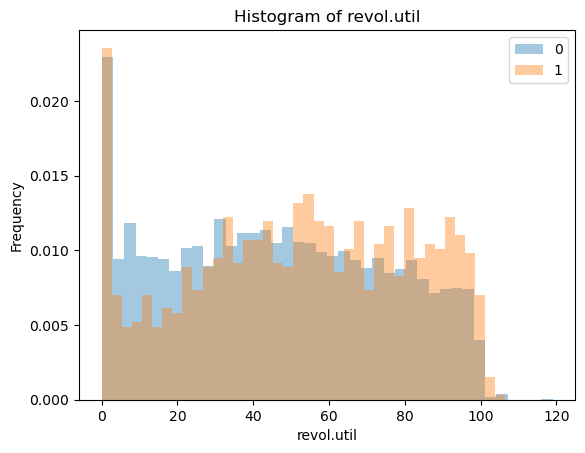

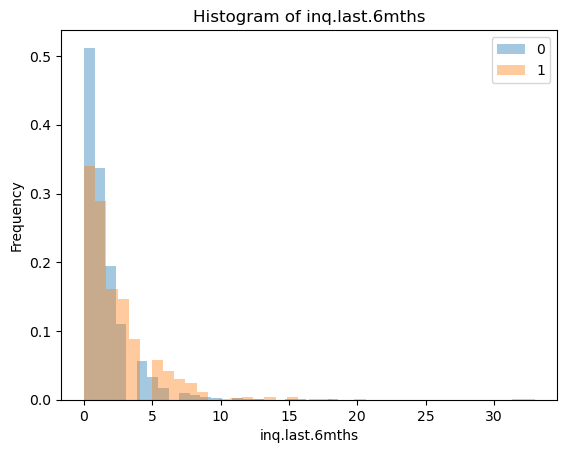

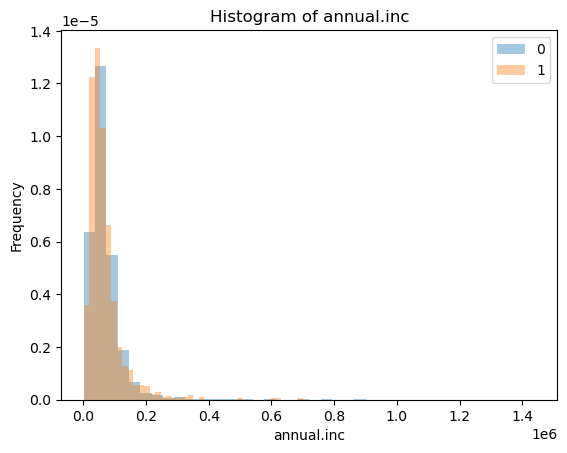

In [71]:
for feat in numeric_cols:
    train_df.groupby("not.fully.paid")[feat].plot.hist(bins=40, alpha=0.4, legend=True, density=True, title = "Histogram of " + feat)
    plt.xlabel(feat)
    plt.show()

In [72]:
# Data distribution of selected loan features
numeric_cols_hists = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=20)),  
    y='count()'
).properties(
    width=250,
    height=175
).repeat(
    ['installment', 'dti'],  
    columns=3
)

numeric_cols_hists

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.RepeatChart(...)

In [73]:
# Default Rate by Loan Purpose:

# Explode 'purpose' column for analysis
loan_purpose_data = train_df.explode('purpose')

# Loan Category vs Loan Purpose
purpose_risk_chart = alt.Chart(loan_purpose_data).mark_circle().encode(
    x=alt.X('loan_categories:N', title='Loan Categories', sort='-color', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('purpose:N', title='Loan Purpose', sort='color'),
    color=alt.Color('count()', scale=alt.Scale(scheme='viridis'), title='Loan Count'),
    size=alt.Size('count()', title='Loan Count', scale=alt.Scale(range=[50, 1500])),
    tooltip=['purpose', 'loan_categories', 'count()']
).properties(
    width=600,
    height=400,
    title="Loan Category vs Loan Purpose"
)

purpose_risk_chart

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.Chart(...)

We have a high concentration of loans in the medium risk category and significant number low risk borrowers as compared to the high risk borrowers.

In [74]:

categories_hist = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('risk_category:N', title='Risk Categories', axis=alt.Axis(labelAngle=0)),  
    y=alt.Y('count()', title='Count') 
).properties(
    height=300,
    width=400,
    title="Distribution of Risk Categories"
)

categories_hist

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.Chart(...)

In [75]:
#fico by loan purpose
purpose_fico_boxplot = alt.Chart(loan_purpose_data).mark_boxplot().encode(
    y=alt.Y('purpose:N', title='Loan Purpose', sort='-x'),  
    x=alt.X('fico:Q', title='FICO Score', scale=alt.Scale(domain=[600, 850]),),  
    color=alt.Color('purpose:N', legend=None),  
    tooltip=['purpose', 'fico']
).properties(
    width=400,
    height=200,
    title='Boxplot of FICO Scores by Loan Purpose'
)


#Debt to income ratio by risk level
risk_dti_boxplot = alt.Chart(train_df).mark_boxplot().encode(
    y=alt.Y('risk_category:N', title='Risk Category', sort='-x'),  
    x=alt.X('dti:Q', title='DTI (Debt-to-Income)', scale=alt.Scale(domain=[0, 35])),  
    color=alt.Color('risk_category:N', legend=None),  
    tooltip=['risk_category', 'dti']
).properties(
    width=400,
    height=200,
    title='Boxplot of DTI by Risk Category'
)


purpose_fico_boxplot & risk_dti_boxplot



MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000).

See https://altair-viz.github.io/user_guide/large_datasets.html for information on how to plot large datasets, including how to install third-party data management tools and, in the right circumstance, disable the restriction

alt.VConcatChart(...)

From the boxplot above, we see that the low risk borrowers have lower average debt-to-income-ratio as compared to the borrowers with medium and high risk profile, based on their fico score. Note also the outliers in FICO scores for the loan purpose of debt consolidation type.


#### 4.4 Correlation Analysis
The EDA for most of the numerical columns produce no strong general trends. 
We see a higher correlation level between fico and revo.util, and that of fico and interest rate



In [76]:
# Select only numeric columns
numeric_cols = train_df[['int.rate', 'installment', 'log.annual.inc', 'dti', 
                         'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 
                         'inq.last.6mths', 'annual.inc']]
# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr().reset_index().melt('index')
correlation_matrix.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Create a heatmap using Altair
correlation_chart = alt.Chart(correlation_matrix).mark_rect().encode(
    x=alt.X('Variable 1:N', title='', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Variable 2:N', title=''),
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Variable 1', 'Variable 2', 'Correlation']
).properties(
    width=400,
    height=400,
    title="Correlation Heatmap"
)

correlation_chart


/Users/yasminhassan/miniforge3/envs/loan_risk522/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/Users/yasminhassan/miniforge3/envs/loan_risk522/lib/python3.11/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

####  4.5 Data Transformation and Preprocessing <br>
Since both `risk_category` and `loan_categories` are dereived from `fico`, we decided to drop the `fico` and `risk_category` 

In [21]:
# Split into training and testing sets
# Features
X_train = train_df.drop(columns=['not.fully.paid'])  
X_test = test_df.drop(columns=['not.fully.paid' ]) 

# Target
y_train = train_df['not.fully.paid']               
y_test = test_df['not.fully.paid']               


In [22]:
# Define numeric and categorical columns
numeric_features = [
    'int.rate', 'installment', 'log.annual.inc', 'loan_income_ratio', 'dti', 
    'days.with.cr.line', 'revol.bal', 'revol.util', "fico",
    'inq.last.6mths', 'delinq.2yrs', 'pub.rec', "credit.policy"
]
categorical_features = ['purpose']

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())                   # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))     # Encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [23]:
# Save transformed data to csv
set_config(transform_output="pandas")
preprocessor.fit(train_df)
scale_train = preprocessor.transform(train_df)
scale_train.to_csv("../data/processed/scaled_loan_train.csv")
scale_test = preprocessor.transform(test_df)
scale_test.to_csv("../data/processed/scaled_loan_test.csv")


####  4.6 Model Building<br>

First we performed 10-folds cross-evaluation on four classifier models: DecisionTree, kNN-neighbours, SVC and Logistic Regression. 

In [24]:
# Define Models
dt = DecisionTreeClassifier(random_state=123)
knn = KNeighborsClassifier(n_jobs=-1)
svc = SVC(random_state=123)
log_reg = LogisticRegression(random_state=123)

models = {"Decision Tree": dt, 
          "kNN": knn,
          "SVC": svc,
          "Logistic Regression": log_reg}


def model_cross_val(model):

    '''Perform 10-fold cross-validation on the given machine learning model 
    using a preprocessing pipeline. Returns a dictionary'''
    
    model_pipeline = Pipeline([
            ('preprocessor', preprocessor),  
            ('model', model)
    ])

    results = pd.DataFrame(cross_validate(
        model_pipeline, X_train, y_train, return_train_score=True, cv=10
    ))

    mean_std = pd.DataFrame({"mean":results.mean(),
                             "stdev":results.std()})
    
    result_dict = {index: f"{mu:.3f}(+/-{std:.3f})" # Concat std with mean
                   for (index, mu, std) in mean_std.itertuples()}
    
    return result_dict

cv_results = pd.DataFrame()
for (name, model) in models.items():
    cv_results[name] = model_cross_val(model)
cv_results = cv_results.T

cv_results


,fit_time,score_time,test_score,train_score
Decision Tree,0.073(+/-0.011),0.003(+/-0.000),0.742(+/-0.014),1.000(+/-0.000)
kNN,0.010(+/-0.001),0.018(+/-0.007),0.821(+/-0.007),0.855(+/-0.002)
SVC,0.677(+/-0.014),0.085(+/-0.004),0.841(+/-0.002),0.845(+/-0.000)
Logistic Regression,0.013(+/-0.000),0.002(+/-0.000),0.839(+/-0.004),0.840(+/-0.000)


From the mean validation score and training score, we can see that the decision tree model has a much smaller cross-validation score compared to the other three models. 

While the SVC model has a slightly larger test score than the logistic model, it requires a significantly longer computation time. Since the test score for SVC and Logistic Regression is very similar (both being ~0.84), We have opt for the logistic regression model as our predictor. 

The train score of the Logistic Regression is the same as the validation score, suggesting that the model is likely not overfitted and will be able to generalize well to unseen data. While together with the fact that SVC has a significantly longer computation time,

In [25]:
# Logistic Regression Tuning
log_reg_param_dist = {
    "LogReg__C": np.logspace(-5, 5)
}

log_reg_pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('LogReg', LogisticRegression(random_state=123, max_iter=20000))
])

log_reg_search = GridSearchCV(
    log_reg_pipe,
    param_grid=log_reg_param_dist,
    cv=10,
    n_jobs=-1,
    return_train_score=True
)

log_reg_search.fit(X_train, y_train)
cv_results = pd.DataFrame(log_reg_search.cv_results_)[[
    "rank_test_score",
    "param_LogReg__C",
    "mean_test_score",
    "mean_train_score"
]]

In [26]:
cv_results.sort_values(by="rank_test_score").head(5)

,rank_test_score,param_LogReg__C,mean_test_score,mean_train_score
9,1,0.000687,0.839989,0.839990
12,2,0.002812,0.839989,0.839743
0,3,0.000010,0.839859,0.839859
1,3,0.000016,0.839859,0.839859
2,3,0.000026,0.839859,0.839859


In [27]:
y_pred_log_reg = log_reg_search.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Model Accuracy: {accuracy_log_reg:.4f}")

Logistic Regression Model Accuracy: 0.8392


In [28]:
pred_true = pd.DataFrame({"prediction":y_pred_log_reg, "true":y_test})
results_log_reg = pd.DataFrame(
    {   
         " ": ["True Positive (defaulted)", "True Negative (fully paid)"],
        "Predict Positive (defaulted)": [
            len(pred_true.query("prediction == 1 & true == 1")),
            len(pred_true.query("prediction == 1 & true == 0"))
            
        ],
        "Predict Negative (fully paid)": [
            len(pred_true.query("prediction == 0 & true == 1")),
            len(pred_true.query("prediction == 0 & true == 0"))
    
        ]
    }
)
results_log_reg

,,Predict Positive (defaulted),Predict Negative (fully paid)
0,True Positive (defaulted),0,306
1,True Negative (fully paid),2,1608


Here, we identify the top 5 influential features for predicting each class.
The Logistic Regression's coefficients provide insights into feature importance, highlighting predictors such as:

fico: Higher credit score were strongly correlated with lower default risk.

loan_income_ratio: Borrowers with higher loan-to-income ratios exhibited a greater likelihood of default.

log.annual.inc: Borrowers with higher log annual income correlates with lower default risk.

int.rate: Borrowers with higher interest rates has a greater likelihood of default.

inq.last.6mths: Borrowers that has more inquires in the past 6 months has a higher default risk.

In [29]:
preprocessor.fit(X_train)
coefficients = log_reg_search.best_estimator_.named_steps['LogReg'].coef_[0]

pd.DataFrame(
    {"features":preprocessor.get_feature_names_out(),
     "negative coefficient": coefficients}
).sort_values(by="negative coefficient", ascending=True, ignore_index=True).head(3)

,features,negative coefficient
0,num__fico,-0.104898
1,num__credit.policy,-0.102413
2,num__log.annual.inc,-0.038816


In [30]:
pd.DataFrame(
    {"features":preprocessor.get_feature_names_out(),
     "positive coefficient": coefficients}
).sort_values(by="positive coefficient", ascending=False, ignore_index=True).head(3)

,features,positive coefficient
0,num__int.rate,0.115715
1,num__inq.last.6mths,0.111241
2,num__loan_income_ratio,0.068905


On the test set, the model correctly predicted 1608 cases out of 1916, with 308 errors. 
These errors were distributed across false positives and false negatives. False negatives, representing cases where a defaulted loan was not flagged, pose a greater financial risk, as these borrowers are likely to incur losses. False positives, on the other hand, might result in stricter lending requirements for borrowers who would have successfully repaid their loans.

Despite the high accuracy score, our model fails to identify any of the 306 actual defaults loan. This suggest that the accuracy score is unable to fully reflect the model performance. Though our model is a great predictor in identifying negative loan defaults (over 99% of the fully paid cases identified), the high false negative makes its real life application limited. Further steps is needed to improve the model such that it can also predict defaulted loans well.




#### 4.8 Limitations


In [31]:
train_df["not.fully.paid"].value_counts(normalize=True)

not.fully.paid
0    0.839859
1    0.160141
Name: proportion, dtype: float64

As we check the distribution of the target, we can see that the proportion of borrowers that has repayed their loans is significantly higher than those who defaulted their loans. 
The class imbalance of the target results in the model predicting most cases as "negative" (fully paid). 

Possible solutions to the high false negtative include adjusting the `class_weight` hyperparameter or adjusting the decision threshold of the logistic model. Since accuracy might not fully reflect the model performance in the case of class imbalance, it would be good to include other evaluation metrics when evaulating model performance. 

Also, based on the feature importances obtained, additional feature engineering or feature selection can potentially improve model performance. 

To account for possible non-linear decision boundary, another alternative is to use a non-linear classification model, for example a decision tree, which can model complex non-linear decision boundaries better.


# Reference
1. Cai, S., Lin, X., Xu, D., & Fu, X. (2016). Judging online peer-to-peer lending behavior: A comparison of first-time and repeated borrowing requests. Information & Management, 53(7), 857-867.Consumer
2. Coşer, A., Maer-Matei, M. M., & Albu, C. (2019). PREDICTIVE MODELS FOR LOAN DEFAULT RISK ASSESSMENT. Economic Computation & Economic Cybernetics Studies & Research, 53(2).
3. Equifax. (n.d.). *Credit score ranges.* Retrieved November 20, 2024, from [https://www.equifax.com/personal/education/credit/score/articles/-/learn/credit-score-ranges/](https://www.equifax.com/personal/education/credit/score/articles/-/learn/credit-score-ranges/)
4. Financial Protection Bureau. (n.d.). *Borrower risk profiles: Student loans*. Retrieved November 20, 2024, from [https://www.consumerfinance.gov/data-research/consumer-credit-trends/student-loans/borrower-risk-profiles/](https://www.consumerfinance.gov/data-research/consumer-credit-trends/student-loans/borrower-risk-profiles/)
5. Khandani, A. E., Kim, A. J., & Lo, A. W. (2010). Consumer credit-risk models via machine-learning algorithms. Journal of Banking & Finance, 34(11), 2767-2787.
8. Lenz, R. (2016). Peer-to-peer lending: Opportunities and risks. European Journal of Risk Regulation, 7(4), 688-700
9. myFICO. (n.d.). *What's in my FICO® Scores?* Retrieved November 20, 2024, from [https://www.myfico.com/credit-education/whats-in-your-credit-score](https://www.myfico.com/credit-education/whats-in-your-credit-score#:~:text=FICO%20Scores%20are%20calculated%20using,and%20credit%20mix%20(10%25)
   
